In [1]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar100
import numpy as np
import os

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 100:
        lr *= 1e-3
    elif epoch > 70:
        lr *= 1e-2
    elif epoch > 25:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = keras.layers.Dropout(0.1)(x)
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = keras.layers.Dropout(0.1)(x)
        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model
  

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
direc = '/content/gdrive/My Drive/saved_models/cifar100_impr_drop/'

In [0]:
cifar100_32v1_history = pd.read_csv(direc+'ResNet32v1_Drop01_2/'+'history.csv')
cifar100_44v1_history = pd.read_csv(direc+'ResNet44v1_Drop01_2/'+'history.csv')
cifar100_80v1_history = pd.read_csv(direc+'ResNet80v1_Drop01_cifar100_2/'+'history.csv')

In [0]:
cifar100_44v1_gr_history = pd.read_csv(direc+'ResNet32v1_Drop01_2/grow50/'+'history_gr.csv')
cifar100_80v1_gr_history = pd.read_csv(direc+'ResNet44v1_Drop01_2/grow50n=13/'+'history_gr.csv')

In [0]:
r32v1_gr_hist_acc =list(cifar100_32v1_history['acc'][:50])+list(cifar100_44v1_gr_history['acc'])
r32v1_gr_hist_val_acc =list(cifar100_32v1_history['val_acc'][:50])+list(cifar100_44v1_gr_history['val_acc'])
r44v1_gr_hist_acc =list(cifar100_44v1_history['acc'][:50])+list(cifar100_80v1_gr_history['acc'])
r44v1_gr_hist_val_acc =list(cifar100_44v1_history['val_acc'][:50])+list(cifar100_80v1_gr_history['val_acc'])


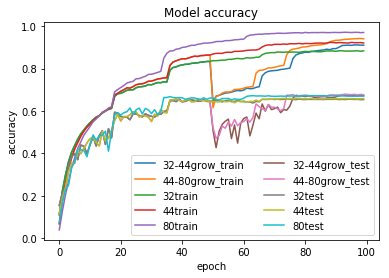

In [7]:
import matplotlib.pyplot as plt
plt.plot(r32v1_gr_hist_acc)
plt.plot(r44v1_gr_hist_acc)
plt.plot(cifar100_32v1_history['acc'])
plt.plot(cifar100_44v1_history['acc'])
plt.plot(cifar100_80v1_history['acc'])
plt.plot(r32v1_gr_hist_val_acc)
plt.plot(r44v1_gr_hist_val_acc)
plt.plot(cifar100_32v1_history['val_acc'])
plt.plot(cifar100_44v1_history['val_acc'])
plt.plot(cifar100_80v1_history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['32-44grow_train',  '44-80grow_train', '32train', '44train', '80train', '32-44grow_test', '44-80grow_test',  '32test',  '44test',  '80test'], loc='lower right', ncol = 2)
plt.show()

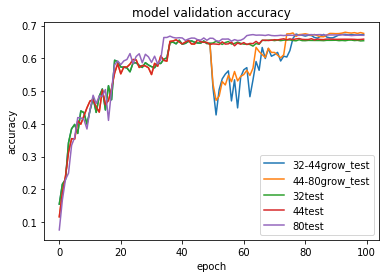

In [8]:
import matplotlib.pyplot as plt
#plt.plot(r32v1_gr_hist_acc)
plt.plot(r32v1_gr_hist_val_acc)
#plt.plot(r44v1_gr_hist_acc)
plt.plot(r44v1_gr_hist_val_acc)
#plt.plot(cifar100_32v1_history['acc'])
plt.plot(cifar100_32v1_history['val_acc'])
#plt.plot(cifar100_44v1_history['acc'])
plt.plot(cifar100_44v1_history['val_acc'])
#plt.plot(cifar100_80v1_history['acc'])
plt.plot(cifar100_80v1_history['val_acc'])
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([ '32-44grow_test',  '44-80grow_test' , '32test',  '44test',  '80test'], loc='lower right')
plt.show()

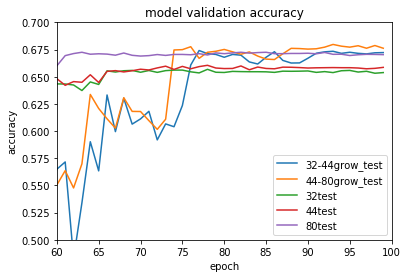

In [9]:
import matplotlib.pyplot as plt
plt.xlim((60, 100))
plt.ylim((0.5, 0.7))
#plt.plot(r32v1_gr_hist_acc)
plt.plot(r32v1_gr_hist_val_acc)
#plt.plot(r44v1_gr_hist_acc)
plt.plot(r44v1_gr_hist_val_acc)
#plt.plot(cifar100_32v1_history['acc'])
plt.plot(cifar100_32v1_history['val_acc'])
#plt.plot(cifar100_44v1_history['acc'])
plt.plot(cifar100_44v1_history['val_acc'])
#plt.plot(cifar100_80v1_history['acc'])
plt.plot(cifar100_80v1_history['val_acc'])
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([ '32-44grow_test',  '44-80grow_test' , '32test',  '44test',  '80test'], loc='lower right')
plt.show()

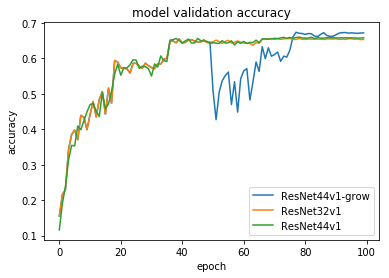

In [10]:
import matplotlib.pyplot as plt

plt.plot(r32v1_gr_hist_val_acc)

plt.plot(cifar100_32v1_history['val_acc'])

plt.plot(cifar100_44v1_history['val_acc'])
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([ 'ResNet44v1-grow',  'ResNet32v1',  'ResNet44v1'], loc='lower right')
plt.show()

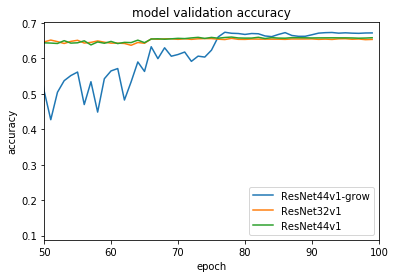

In [11]:
plt.xlim((50, 100))
plt.plot(r32v1_gr_hist_val_acc)

plt.plot(cifar100_32v1_history['val_acc'])

plt.plot(cifar100_44v1_history['val_acc'])
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([ 'ResNet44v1-grow',  'ResNet32v1',  'ResNet44v1'], loc='lower right')
plt.show()

In [0]:
cifar10_44v1_history = pd.read_csv(direc+'ResNet44v1_Drop01_cifar10/'+'history.csv')
cifar10_32v1_history = pd.read_csv(direc+'ResNet32v1_Drop01_cifar10/'+'history.csv')
cifar10_44v1_gr_history = pd.read_csv(direc+'ResNet32v1_Drop01_cifar10/grow50/'+'history_gr.csv')

In [13]:
r32v1_c10_gr_hist_acc =list(cifar10_32v1_history['acc'][:50])+list(cifar10_44v1_gr_history['acc'])
r32v1_c10_gr_hist_val_acc =list(cifar10_32v1_history['val_acc'][:50])+list(cifar10_44v1_gr_history['val_acc'])
len(r32v1_c10_gr_hist_acc)

100

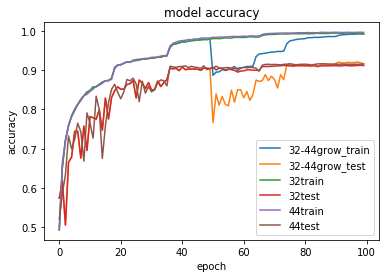

In [14]:
import matplotlib.pyplot as plt
plt.plot(r32v1_c10_gr_hist_acc)
plt.plot(r32v1_c10_gr_hist_val_acc)
plt.plot(cifar10_32v1_history['acc'])
plt.plot(cifar10_32v1_history['val_acc'])
plt.plot(cifar10_44v1_history['acc'])
plt.plot(cifar10_44v1_history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['32-44grow_train', '32-44grow_test', '32train', '32test', '44train', '44test'], loc='lower right')
plt.show()

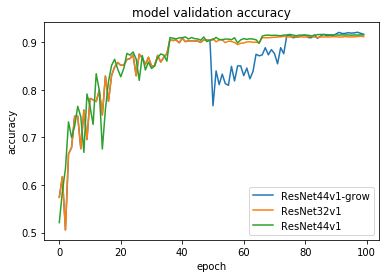

In [15]:
import matplotlib.pyplot as plt

plt.plot(r32v1_c10_gr_hist_val_acc)

plt.plot(cifar10_32v1_history['val_acc'])

plt.plot(cifar10_44v1_history['val_acc'])
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend( ['ResNet44v1-grow',  'ResNet32v1',  'ResNet44v1'], loc='lower right')
plt.show()

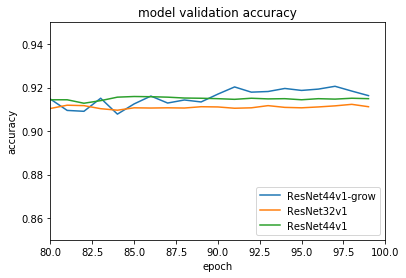

In [16]:
import matplotlib.pyplot as plt

plt.plot(r32v1_c10_gr_hist_val_acc)

plt.plot(cifar10_32v1_history['val_acc'])
plt.xlim((80, 100))
plt.ylim((0.85, 0.95))

plt.plot(cifar10_44v1_history['val_acc'])
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend( ['ResNet44v1-grow',  'ResNet32v1',  'ResNet44v1'], loc='lower right')
plt.show()

In [17]:
model = resnet_v1(input_shape=(32, 32, 3), depth=32, num_classes = 100)

W0613 20:57:26.143546 140031559444352 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0613 20:57:26.195791 140031559444352 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0613 20:57:26.204490 140031559444352 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0613 20:57:26.395379 140031559444352 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0613 20:57:26.396511

In [0]:
#from IPython.display import SVG
#from keras.utils import model_to_dot

from keras.utils import plot_model
plot_model(model, to_file=direc+'ResNet32v1_Drop01_cifar10'+'model.png')

In [0]:
cifar100_47v2_history = pd.read_csv(direc+'ResNet47v2_Drop01_cifar100_2/'+'history.csv')
cifar100_65v2_history = pd.read_csv(direc+'ResNet65v2_Drop01_cifar100_2/'+'history.csv')
cifar100_65v2_gr_history = pd.read_csv(direc+'ResNet47v2_Drop01_cifar100_2/grow50_2/'+'history_gr.csv')
cifar100_92v2_history = pd.read_csv(direc+'ResNet92v2_Drop01_cifar100_2/'+'history.csv')
cifar100_92v2_gr_history = pd.read_csv(direc+'ResNet65v2_Drop01_cifar100_2/grow50_n=10/'+'history_gr.csv')

In [0]:
r47v2_c100_gr_hist_acc =list(cifar100_47v2_history['acc'][:50])+list(cifar100_65v2_gr_history['acc'])
r47v2_c100_gr_hist_val_acc =list(cifar100_47v2_history['val_acc'][:50])+list(cifar100_65v2_gr_history['val_acc'])
r65v2_c100_gr_hist_acc =list(cifar100_65v2_history['acc'][:50])+list(cifar100_92v2_gr_history['acc'])
r65v2_c100_gr_hist_val_acc =list(cifar100_65v2_history['val_acc'][:50])+list(cifar100_92v2_gr_history['val_acc'])

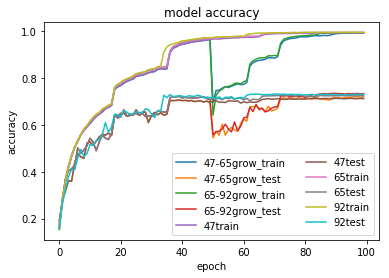

In [21]:
import matplotlib.pyplot as plt
plt.plot(r47v2_c100_gr_hist_acc)
plt.plot(r47v2_c100_gr_hist_val_acc)
plt.plot(r65v2_c100_gr_hist_acc)
plt.plot(r65v2_c100_gr_hist_val_acc)
plt.plot(cifar100_47v2_history['acc'])
plt.plot(cifar100_47v2_history['val_acc'])
plt.plot(cifar100_65v2_history['acc'])
plt.plot(cifar100_65v2_history['val_acc'])
plt.plot(cifar100_92v2_history['acc'])
plt.plot(cifar100_92v2_history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['47-65grow_train', '47-65grow_test', '65-92grow_train', '65-92grow_test', '47train', '47test', '65train', '65test', '92train', '92test'], loc='lower right', ncol = 2)
plt.show()

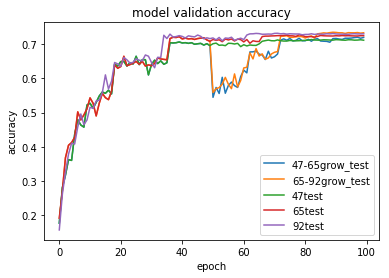

In [22]:
import matplotlib.pyplot as plt
#plt.plot(r47v2_c100_gr_hist_acc)
plt.plot(r47v2_c100_gr_hist_val_acc)
#plt.plot(r65v2_c100_gr_hist_acc)
plt.plot(r65v2_c100_gr_hist_val_acc)
#plt.plot(cifar100_47v2_history['acc'])
plt.plot(cifar100_47v2_history['val_acc'])
#plt.plot(cifar100_65v2_history['acc'])
plt.plot(cifar100_65v2_history['val_acc'])
#plt.plot(cifar100_92v2_history['acc'])
plt.plot(cifar100_92v2_history['val_acc'])
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([ '47-65grow_test',  '65-92grow_test',  '47test',  '65test',  '92test'], loc='lower right')
plt.show()

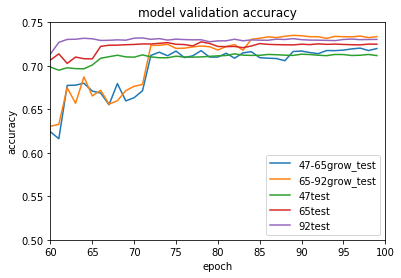

In [23]:
import matplotlib.pyplot as plt
plt.xlim((60, 100))
plt.ylim((0.5, 0.75))
#plt.plot(r47v2_c100_gr_hist_acc)
plt.plot(r47v2_c100_gr_hist_val_acc)
#plt.plot(r65v2_c100_gr_hist_acc)
plt.plot(r65v2_c100_gr_hist_val_acc)
#plt.plot(cifar100_47v2_history['acc'])
plt.plot(cifar100_47v2_history['val_acc'])
#plt.plot(cifar100_65v2_history['acc'])
plt.plot(cifar100_65v2_history['val_acc'])
#plt.plot(cifar100_92v2_history['acc'])
plt.plot(cifar100_92v2_history['val_acc'])
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([ '47-65grow_test',  '65-92grow_test',  '47test',  '65test',  '92test'], loc='lower right')
plt.show()

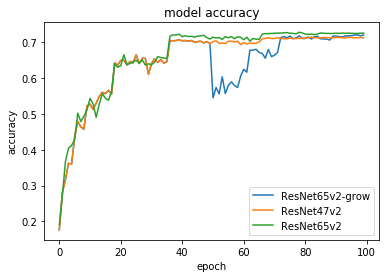

In [24]:
import matplotlib.pyplot as plt
plt.plot(r47v2_c100_gr_hist_val_acc)

plt.plot(cifar100_47v2_history['val_acc'])

plt.plot(cifar100_65v2_history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['ResNet65v2-grow',  'ResNet47v2',  'ResNet65v2'], loc='lower right')
plt.show()

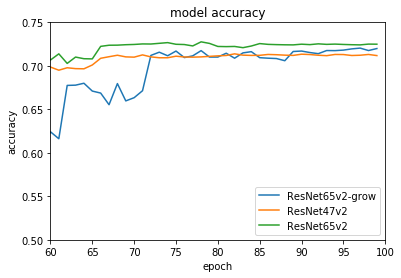

In [25]:
import matplotlib.pyplot as plt
plt.plot(r47v2_c100_gr_hist_val_acc)
plt.xlim((60, 100))
plt.ylim((0.5, 0.75))
plt.plot(cifar100_47v2_history['val_acc'])

plt.plot(cifar100_65v2_history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['ResNet65v2-grow',  'ResNet47v2',  'ResNet65v2'], loc='lower right')
plt.show()

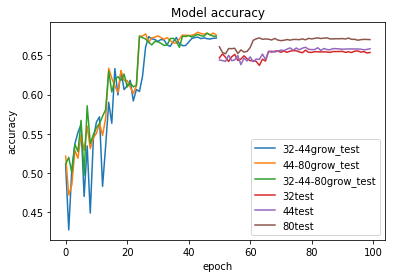

In [34]:

cifar100_80v1_gr_history = pd.read_csv(direc+'ResNet44v1_Drop01_2/grow50n=13/'+'history_gr.csv')
cifar100_32_44_80v1_gr_history = pd.read_csv(direc+'ResNet32v1_Drop01_2/grow50/grow50n=13/'+'history_gr.csv')

import matplotlib.pyplot as plt

plt.plot(r32v1_gr_hist_val_acc[50:])
plt.plot(r44v1_gr_hist_val_acc[50:])
plt.plot(cifar100_32_44_80v1_gr_history['val_acc'])
plt.plot(cifar100_32v1_history['val_acc'][50:])
plt.plot(cifar100_44v1_history['val_acc'][50:])
plt.plot(cifar100_80v1_history['val_acc'][50:])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['32-44grow_test',  '44-80grow_test', '32-44-80grow_test',   '32test',  '44test',  '80test'], loc='lower right', ncol = 1)
plt.show()
